# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.60KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

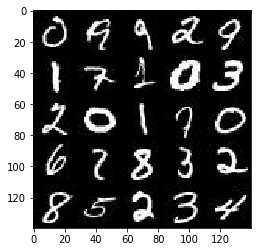

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

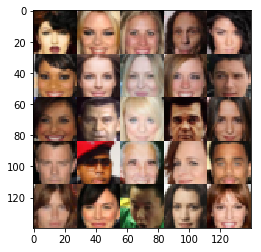

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.20):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1, 4*4*256))
        
        logits= tf.layers.dense(flattened, 1)
        out= tf.sigmoid(logits)
    
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.10
    with tf.variable_scope('generator',reuse=not is_train): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9)
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    discriminators = [x for x in train_vars if x.name.startswith('discriminator')]
    generators = [x for x in train_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminators)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generators)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate_pl = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_pl, beta1)
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            for batch_images in get_batches(batch_size):
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_pl:learning_rate})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_pl:learning_rate})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_pl:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0048... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 2.1738... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 2.0367
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.6500
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 1.1839


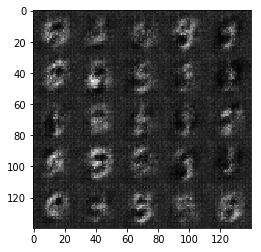

Epoch 1/2... Discriminator Loss: 1.5272... Generator Loss: 1.3693
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 1.3773
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 1.3519
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 1.4053
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 1.4939


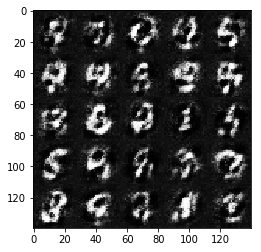

Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.1529
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 1.3394
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 1.2515
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 1.3982
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 1.3254
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 1.4278
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 1.3444


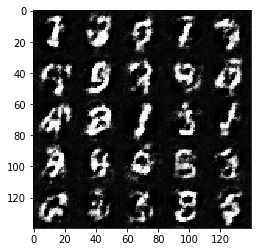

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 1.3463
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 1.3107
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 1.4693
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 1.2413
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 1.2517


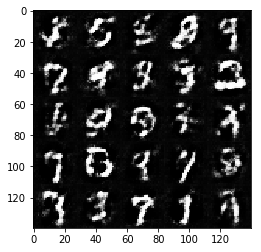

Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 1.2483
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 1.2557
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 1.2400
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 1.2708


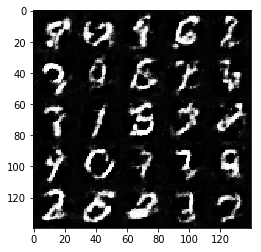

Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 1.1782
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 1.1472
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 1.1279
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 1.0099
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 1.4309


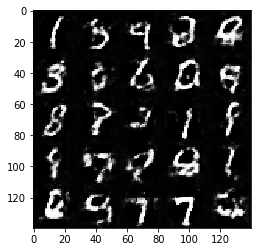

Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 1.1466
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 1.1557
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 1.0234


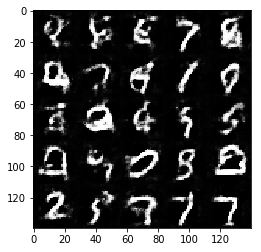

Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 1.1364
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 1.0642


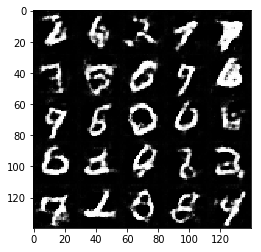

Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 1.1308
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 1.1781
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 1.2346
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 1.1302


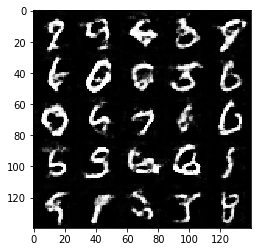

Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 1.1610


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5644... Generator Loss: 0.0757
Epoch 1/1... Discriminator Loss: 2.6858... Generator Loss: 0.3149
Epoch 1/1... Discriminator Loss: 2.5305... Generator Loss: 0.1916
Epoch 1/1... Discriminator Loss: 2.4592... Generator Loss: 0.2106
Epoch 1/1... Discriminator Loss: 1.8884... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 2.2505... Generator Loss: 0.2820
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0258


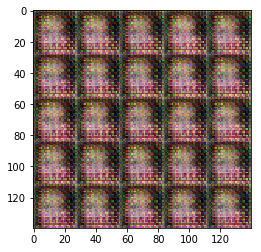

Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 3.2270
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.9574
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.6474


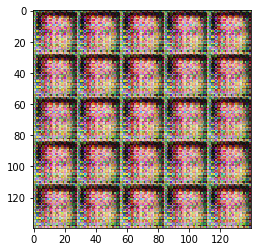

Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 2.3358
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 2.0371
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.4151
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 2.5476
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 2.4879


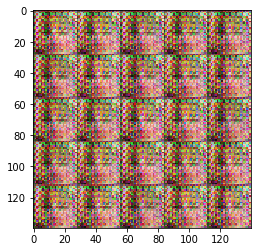

Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.7585
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7674


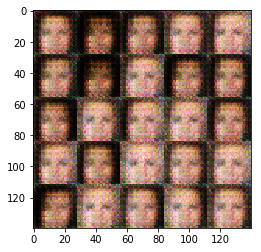

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9416


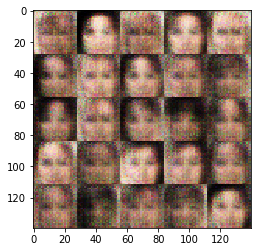

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.7768


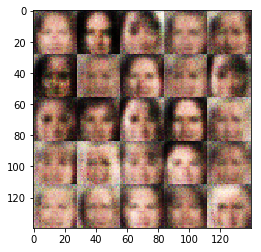

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.8209


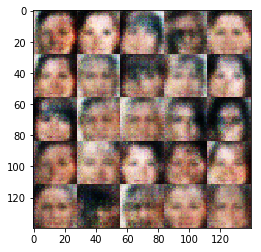

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6404


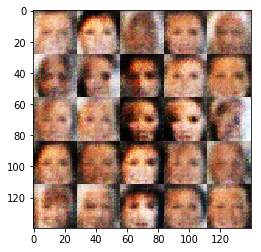

Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7092


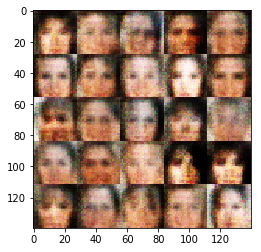

Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6867


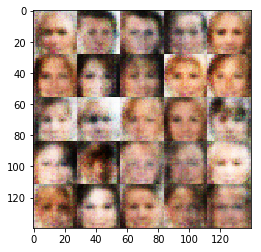

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7630


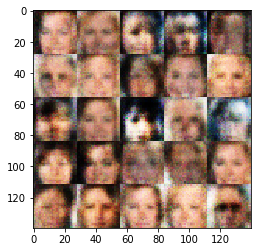

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5975


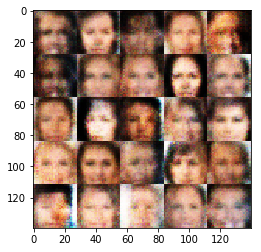

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7081


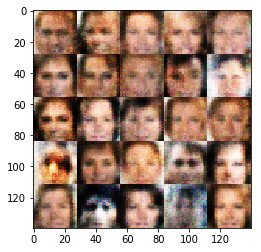

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6675


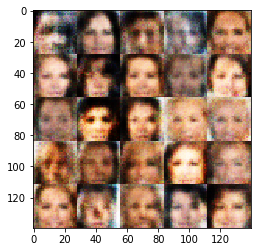

Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6785


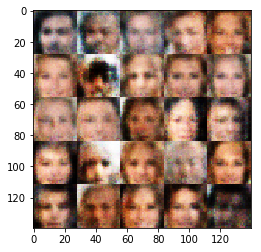

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7614


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.